### Preprocessing - Get Bounding Boxes
Reads json files from Megadetector output and produces cropped images with bouding boxes for each animal found.

Inputs:
- Batch name (name of JLDP folder, i.e. "2139571").
- Path where Megadetector output json files are stored. The files' names follow the convention "output_{batch}.json".

Output:
- Cropped image of every animal found in each image. All images are stored in the "images-bboxes/jldp" folder.
- Since some images show multiple animals, the cropped images are named following the convention "{origname}_{confidence}". Where *origname* is the original image name and *confidence* is Megadetector's confidence of the finding. E.g., if the original image is called "dedbef28-fb10-491f-a8ba-ce5030ebb917.JPG" and Megadetector finds an animal there with 47.1% of confidence, the new cropped image for this specific finding will be called ""dedbef28-fb10-491f-a8ba-ce5030ebb917_471.JPG".

In [3]:
import json
import cv2
import matplotlib.pyplot as plt

%matplotlib inline

In [4]:
# read json output for given batch
def read_file(path, batch):
    with open(f"{path}/output_{batch}.json") as json_file:
        data = json.load(json_file)
    return data

In [5]:
# obtain relevant detections from the data
def get_detections(data, threshold):

    # lists to store images where megadetector confidently recognized animals
    # and the detection information that it captured
    img_names = []
    img_detection = []

    for img in data["images"]:
        
        # if nothing was detected in this image, move on to next
        if "detections" not in img.keys():
            continue
            
        file_name = img["file"]
        detections = img["detections"]
        
        for detection in detections:
            # skip if the detector is not at least threshold% confident
            if detection["conf"] < threshold:
                continue
            
            # skip if it's not an animal
            if detection["category"] != "1":
                continue
            
            else:
                img_names.append(file_name)
                img_detection.append(detection)
                
    return (img_names, img_detection)

In [6]:
# add rectangle with given bounding box coordinates to given image
def add_bbox(img, box):
    y_dim, x_dim, _ = img.shape
    
    # coordinates are given in relative terms so need to convert them to absolute values
    x0 = round(box[0] * x_dim)
    x1 = x0 + round(box[2] * x_dim)
    y0 = round(box[1] * y_dim)
    y1 = y0 + round(box[3] * y_dim)
    
    # (x0, y0) are coordinates of the the top left corner of bounding box
    # (x0+x1, y0+y1) are the coordinates of the bottom right corner of bounding box

    start_point = (x0, y0)
    end_point = (x1, y1)

    return cv2.rectangle(img, start_point, end_point, color=(255,0,0), thickness=2)

In [7]:
# crop given image based on bounding box coordinatees
def crop_box(img, box):
    y_dim, x_dim, _ = img.shape
    
    # coordinates are given in relative terms so need to convert them to absolute values
    x0 = round(box[0] * x_dim)
    x1 = x0 + round(box[2] * x_dim)
    y0 = round(box[1] * y_dim)
    y1 = y0 + round(box[3] * y_dim)
    
    return img[y0:y1, x0:x1, :]

In [17]:
# write images with bounding boxes to given path
# and return list with modified images
def write_bb_img(img_names, img_detections, batch, path):
    
    for name, det in zip(img_names, img_detections):
        img_name = f"images/jldp/{batch}/prod/directUpload/{name}"
        img = cv2.imread(img_name)
        box = det["bbox"]
        conf = int(det["conf"] * 1000)
        
        # img_bbox = add_bbox(img, box)
        img_bbox = crop_box(img, box)
    
        split_name = name.split(".")
        new_name = f"{split_name[0]}_{conf}.{split_name[1]}"
        full_path = f"{path}/{new_name}"
        # print(full_path)
        
        cv2.imwrite(full_path, img_bbox)

In [19]:
batches = ["2139502", "2139503", "2139504", "2139505", "2139506", # "2139507",
          "2139508", "2139509", "2139510", "2139511", "2139513", "2139514",
          "2139515", "2139516", "2139517", "2139518", "2139519", "2139520",
          "2139533", "2139534", "2139537", "2139539", "2139540", "2139543",
          "2139545", "2139547", "2139548", "2139569", "2139570", "2139571",
          "2139572", "2139573", "2139574", "2252500", "2252784", "2252786",
          "2252892"]

# batches = ["2139507"]
input_path = "megadetector-output-jldp"
output_path = "images-bboxes/jldp"

threshold = 0.45
for batch in batches:
    data = read_file(input_path, batch)
    img_names, img_detections = get_detections(data, threshold)
    write_bb_img(img_names, img_detections, batch, output_path)

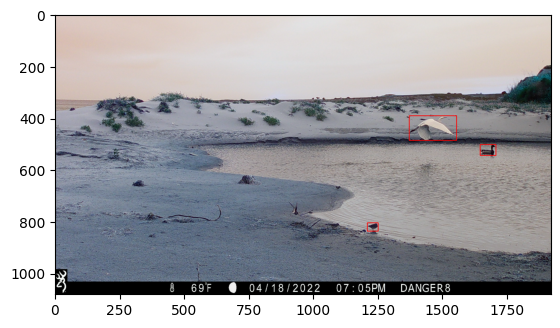

In [29]:
plt.imshow(img_bbox)